In [94]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import numpy as np
import tensorflow as tf
import fddb_data
import keras
import importlib
import config
importlib.reload(config)
importlib.reload(fddb_data)

batch_size = 4
image_size = 224

config = config.Config()

已读取0个......
已读取100个......
已读取200个......
已读取300个......
已读取400个......
已读取500个......
已读取600个......
已读取700个......
已读取800个......
已读取900个......
已读取1000个......
已读取1100个......
已读取1200个......
已读取1300个......
已读取1400个......
已读取1500个......
已读取1600个......
已读取1700个......
已读取1800个......
已读取1900个......
已读取2000个......
已读取2100个......
已读取2200个......
已读取2300个......
已读取2400个......
已读取2500个......
已读取2600个......


E:\projects-deep\keras-faster-rcnn\fddb_data.py:136: RuntimeWarning: invalid value encountered in log
  rpn_bboxes[ix] = [(gt_centy - a_centy)/a_h, (gt_centx - a_centx)/a_w, np.log(gt_h / a_h), np.log(gt_w / a_w)]


[ 0  0  0 ...  0 -1  0]
[[10.82757259 47.72970773  6.84737029 11.89002956]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.  

In [95]:
imgList, bboxList, class_idList, rpn_matchList, rpn_bboxesList = fddb_data.getAllImage()
print(len(imgList))

已读取0个......
已读取100个......
已读取200个......
已读取300个......
已读取400个......
已读取500个......
已读取600个......
已读取700个......
已读取800个......
已读取900个......
已读取1000个......
已读取1100个......
已读取1200个......
已读取1300个......
已读取1400个......
已读取1500个......
已读取1600个......
已读取1700个......
已读取1800个......
已读取1900个......
已读取2000个......
已读取2100个......
已读取2200个......
已读取2300个......
已读取2400个......
已读取2500个......
已读取2600个......
229


In [96]:
class BatchNorm(KL.BatchNormalization):
    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)
    
# ResNet网络 的building_block
# filter：卷积核的通道数
# block：block的标识
def building_block(filters, block):
    if block != 0:
        stride = 1
    else:
        stride = 2
    
    def f(x):
        y = KL.Conv2D(filters, (1,1), strides=stride)(x)  # 卷积核1×1
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(filters, (3,3), padding="same")(y)  # 卷积核1×1
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(4 * filters, (1,1))(y)
        y = BatchNorm(axis=3)(y)
        
        if block == 0:
            shorcut = KL.Conv2D(4*filters, (1,1), strides=stride)(x)
            shorcut = BatchNorm(axis=3)(shorcut)
        else:
            shorcut = x
        y = KL.Add()([y, shorcut])
        y = KL.Activation("relu")(y)
        return y
    return f

# ResNet网络
def resNet_featureExtractor(inputs):
    x = KL.Conv2D(64, (3,3), padding="same")(inputs)
    x = BatchNorm(axis=3)(x)
    x = KL.Activation("relu")(x)
    
    filters = 64   # 第一个卷积核的通道数
    blocks = [6, 7, 5, 3]    # buildblock的数量  change
    
    for i, block_num in enumerate(blocks):
        for block_id in range(block_num):
            x = building_block(filters, block_id)(x)
        filters = filters * 2
    # 新增，下裁一次
#     x = KL.Conv2D(28, (2,2), strides=2)(x)  # 卷积核1×1
    return x
def rpn_net(inputs, k):
    shared_map = KL.Conv2D(256, (3,3), padding="same")(inputs)
    shared_map = KL.Activation("linear")(shared_map)
    rpn_class = KL.Conv2D(2*k, (1,1))(shared_map)
    rpn_class = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 2]))(rpn_class)
    rpn_class = KL.Activation("linear")(rpn_class)
    rpn_prob = KL.Activation("softmax")(rpn_class)  # 分类的得分
    
    y = KL.Conv2D(4*k, (1,1))(shared_map)
    y = KL.Activation("linear")(y)
    rpn_bbox = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 4]))(y)
    
    return rpn_class, rpn_prob, rpn_bbox

In [97]:
x = KL.Input((image_size, image_size, 3))  # change
fp = resNet_featureExtractor(x)
rpn_class, rpn_prob, rpn_bbox = rpn_net(fp, 9)
model = Model([x], [rpn_class, rpn_prob, rpn_bbox])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1019 (Conv2D)            (None, 224, 224, 64) 1792        input_43[0][0]                   
__________________________________________________________________________________________________
batch_norm_973 (BatchNorm)      (None, 224, 224, 64) 256         conv2d_1019[0][0]                
__________________________________________________________________________________________________
activation_977 (Activation)     (None, 224, 224, 64) 0           batch_norm_973[0][0]             
__________________________________________________________________________________________________
conv2d_102

In [98]:
# 计算分类的loss
def rpn_class_loss(rpn_match, rpn_class_logits):
    ## rpn_match(None, 576, 1)
    ## rpn_class_logits(None, 576, 2)
    rpn_match = tf.squeeze(rpn_match, -1)   # 把最后1给压缩掉，变成1维
    indices = tf.where(K.not_equal(rpn_match, 0))     # 取label不等于0的（也就是取IOU为1和-1的）
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)  # 转换成int型
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)  # prediction
    anchor_class = tf.gather_nd(anchor_class, indices)   # target
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                output=rpn_class_logits, from_logits=True)
    # 过滤异常loss
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss
# 计算框回归的loss
def batch_back(x, counts, num_rows):
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)
def rpn_bbox_loss(target_bbox, rpn_match, rpn_bbox):
    rpn_match = tf.squeeze(rpn_match, -1)   # 把最后1给压缩掉，变成1维
    indices = tf.where(K.equal(rpn_match, 1))   # 取label等于1的
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1) # 一维数据求和
    target_bbox = batch_back(target_bbox, batch_counts, batch_size) #change
    diff = K.abs(target_bbox - rpn_bbox)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")  # 是不是小于1的部分
    loss = less_than_one * 0.5 * diff**2 + (1-less_than_one) * (diff-0.5)
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


input_image = KL.Input(shape=[image_size, image_size,3], dtype=tf.float32)  # change
input_bboxes = KL.Input(shape=[None,4], dtype=tf.float32)     # 真实bbox
input_class_ids = KL.Input(shape=[None], dtype=tf.int32)
input_rpn_match = KL.Input(shape=[None,1], dtype=tf.int32)
input_rpn_bbox = KL.Input(shape=[None,4], dtype=tf.float32)

In [99]:
feature_map = resNet_featureExtractor(input_image)
rpn_class, rpn_prob, rpn_bbox = rpn_net(feature_map, 9) # 每个9有个anchor
loss_rpn_match = KL.Lambda(lambda x: rpn_class_loss(*x), name="loss_rpn_match")(
    [input_rpn_match, rpn_class]
)
loss_rpn_bbox = KL.Lambda(lambda x:rpn_bbox_loss(*x), name="loss_rpn_bbox")(
    [input_rpn_bbox, input_rpn_match, rpn_bbox]
)
model = Model(
    [input_image, input_bboxes, input_class_ids, input_rpn_match, input_rpn_bbox],
    [rpn_class, rpn_prob, rpn_bbox, loss_rpn_match, loss_rpn_bbox]
)
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file="model/model_rpn.png", show_shapes=True)
# model.summary()

loss_lay1 = model.get_layer("loss_rpn_match").output
loss_lay2 = model.get_layer("loss_rpn_bbox").output

model.add_loss(tf.reduce_mean(loss_lay1))
model.add_loss(tf.reduce_mean(loss_lay2))

model.compile(loss=[None]*len(model.output), optimizer=keras.optimizers.SGD(lr=0.00005, momentum=0.9))

model.metrics_names.append("loss_rpn_match")
# model.metrics_tensors.append(tf.reduce_mean(loss_lay1, keep_dims=True))
model.metrics_names.append("loss_rpn_bbox")
# model.metrics_tensors.append(tf.reduce_mean(loss_lay2, keep_dims=True))

In [100]:
def data_Gen(num_batch, batch_size, config):
    print("----------------")
    index = 0
    for iii in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        for i in range(batch_size):
            
            image, bbox, class_id, rpn_match, rpn_bbox = imgList[index], bboxList[index], class_idList[index], rpn_matchList[index], rpn_bboxesList[index]
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)
            index += 1

        print("数据：" + str(index))
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]

total = 100000          # 总数据
steps_per_epoch = 20   # 步长
dataGen = data_Gen(int(total), batch_size, config) # 10000个数据，batch_size=10

# 20 * 5 = 100 1个epochs 跑100数据
# 100000 / 100 = 1000 次玩跑完
# 15

In [101]:
his = model.fit_generator(dataGen, steps_per_epoch=steps_per_epoch, epochs=100)

----------------Epoch 1/3

数据：4
数据：8
数据：12
数据：16
数据：20
数据：24
数据：28
数据：32
数据：36
数据：40
数据：44
20/20 [==============================] - 252s 13s/step - loss: 14.3852
Epoch 2/3
数据：124
20/20 [==============================] - 252s 13s/step - loss: nan
Epoch 3/3
数据：204
 8/20 [===========>..................] - ETA: 2:25 - loss: nan

IndexError: list index out of range

In [36]:
# 224 × 224  batch_size：10  steps_per_epoch：10  rpn_stride：28  scales：[7, 14, 28]  buildblock：[7,7,7]   文件名：model_224_28_[epochs数].h5
model.save_weights("model/model_224_28_10.h5")
# model.load_weights("model/model_material1.h5")

In [65]:
def anchor_refinement(boxes, deltas):
    boxes = tf.cast(boxes, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes
    
def boxes_clip(boxes, window):
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    cliped = tf.concat([y1, x1, y2, x2], axis=1)
    cliped.set_shape((cliped.shape[0], 4))
    return cliped
    
def batch_slice(inputs, graph_fn, batch_size):
    if not isinstance(inputs, list):
        inputs = [inputs]
    output = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (list, tuple)):
            output_slice = [output_slice]
        output.append(output_slice)
    output = list(zip(*output))
    result = [tf.stack(o, axis=0) for o in output]
    if len(result)==1:
        result = result[0]
    return result

In [66]:
import keras.engine as KE

class proposal(KE.Layer):
    def __init__(self, proposal_count, nms_thresh, anchors, batch_size, config=None, **kwargs):
        super(proposal, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.anchors = anchors
        self.nms_thresh = nms_thresh
        self.batch_size = batch_size
        self.config = config
    
    def call(self, inputs):
        probs = inputs[0][:, :, 1]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, (1, 1, 4))
        prenms_num = min(100, self.anchors.shape[0])
        idxs = tf.nn.top_k(probs, prenms_num).indices
        
        probs = batch_slice([probs, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        deltas = batch_slice([deltas, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        anchors = batch_slice([idxs], lambda x:tf.gather(self.anchors,x), self.batch_size)
        refined_boxes = batch_slice([anchors, deltas], lambda x,y:anchor_refinement(x,y), self.batch_size)
        H,W = self.config.image_size[:2]
        windows = np.array([0,0,H,W]).astype(np.float32)
        cliped_boxes = batch_slice([refined_boxes], lambda x:boxes_clip(x, windows), self.batch_size)
        normalized_boxes = cliped_boxes / np.array([H,W,H,W])
        def nms(normalized_boxes, scores):
            idxs_ = tf.image.non_max_suppression(normalized_boxes, scores, self.proposal_count, self.nms_thresh)
            box = tf.gather(normalized_boxes, idxs_)
            pad_num = tf.maximum(self.proposal_count - tf.shape(normalized_boxes)[0],0)
            box = tf.pad(box, [(0,pad_num),(0,0)])
            return box
        proposal_ = batch_slice([normalized_boxes, probs], nms, self.batch_size)
        return proposal_
    
    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

In [72]:
test_data = next(dataGen)[0]
images = test_data[0]
bboxes = test_data[1]
class_ids = test_data[2]
rpn_matchs = test_data[3]
rpn_bboxes = test_data[4]

rpn_class, rpn_prob, rpn_bbox, _, _ = \
                model.predict([images, bboxes, class_ids, rpn_matchs, rpn_bboxes])
# 转tensor
rpn_class = tf.convert_to_tensor(rpn_class)
rpn_prob = tf.convert_to_tensor(rpn_prob)
rpn_bbox = tf.convert_to_tensor(rpn_bbox)

数据：14544


In [73]:
import utils
# change
anchors = utils.anchor_gen(config.featureMap_size, ratios=config.ratios, scales=config.scales, rpn_stride=config.rpn_stride,
                           anchor_stride = config.anchor_stride)
proposals = proposal(proposal_count=15, nms_thresh=0.7, anchors=anchors, batch_size=batch_size, config=config)([rpn_prob, rpn_bbox])

In [74]:
sess = tf.Session()
proposals_ = sess.run(proposals) * image_size # change

In [75]:
import random

ix = random.sample(range(batch_size), 1)[0]
proposal_ = proposals_[ix]
img = images[ix]

[]


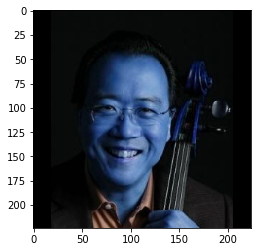

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.imshow(img)
axs = plt.gca()
print(proposal_)
for i in range(len(proposal_)):
    box = proposal_[i]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor='none', edgecolor='r')
    axs.add_patch(rec)